# Loading the needed packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
from pyshred import DataManager, SHRED, SHREDEngine, MLP, PI_SHRED, LSTM
from matplotlib.tri import Triangulation
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Setting the CUDA stuff

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Helper functions (to be put in utilz later on)

In [15]:
from torch.utils.data import DataLoader, random_split

def load_circle_comsol_data(file_path, verbose = False):
    #REMARK... the csv file is saved in a manner without headers. Thus the first row is data, but is currently interpreted as headers.
    #So we are neglecting the first row of data here as for now. This should be fixed in the future.
    
    data = pd.read_csv(file_path)
    names = data.columns 
    X = data[names[0]].values
    Y = data[names[1]].values
    p = data[names[-1]].values
    index = X**2 + Y**2 <0.8**2
    X_inner = X[index]
    Y_inner = Y[index]
    data_inner = data[names[2:]].values[index,:].T
    
    tri = Triangulation(X_inner, Y_inner)
    
    if verbose:
        print(f"Data loaded from {file_path}")
        print(f"Number of spatial points inside the circle: {data_inner.shape[1]}")
        print(f"Number of time steps: {data_inner.shape[0]}")
        
    return data_inner, tri

def generate_circle_sensors_from_tri(nr_sensors, tri,circle_fraction = [0,np.pi*2],scale = 0.6):
    #Which part of the unit circle to sample from
    samples = np.linspace(circle_fraction[0],circle_fraction[1]*(1-1/nr_sensors), nr_sensors)
    X_sample = np.cos(samples)*scale
    Y_sample = np.sin(samples)*scale
    sensor_indices = []
    for i in range(len(samples)):
        idx_temp = np.argmin((X_sample[i]-tri.x)**2+(Y_sample[i]-tri.y)**2)
        sensor_indices.append(idx_temp)
    sensors = [(sensor_indices[i],) for i in range(len(sensor_indices))]
    return sensors


def trajectory_gen(data_list,lags,sensors):
    if not isinstance(data_list, list):
        raise TypeError('data type of data_list must be a list')
    t_dim = data_list[0].shape[0]
    x_dim = data_list[0].shape[1]
    trajectories = np.zeros((t_dim-lags,len(sensors),lags))
    full_states = np.zeros((t_dim-lags,x_dim))
    
    for n, data_temp in enumerate(data_list):       
        for i in range(t_dim-lags):
            for j in range(len(sensors)):
                trajectories[i,j,:] = data_temp[i:i+lags,sensors[j]]
            full_states[i,:] = data_temp[i+lags,:]

        if n < 1:
            X = trajectories.copy()
            y = full_states.copy()
        
        else:
            X = np.vstack((X,trajectories))
            y = np.vstack((y,full_states))
    return X, y

def get_sensor_data(data_list, sensor_locations):
    if not isinstance(data_list, list):
        raise TypeError('data type of data_list must be a list')
    
    t_dim = data_list[0].shape[0]
    sensor_measurements_temp = np.zeros((t_dim, len(sensor_locations)))
    for n, data_temp in enumerate(data_list):
        for j, sensor in enumerate(sensor_locations):
            sensor_measurements_temp[:, j] = data_temp[:, sensor]
        if n < 1:
           sensor_measurements = sensor_measurements_temp.copy()
        else:
           sensor_measurements = np.vstack((sensor_measurements, sensor_measurements_temp))
    return sensor_measurements


def data_prepare(data_list, lags, sensors):
    sensor_measurements = get_sensor_data(data_list, sensors)
    scaler = MinMaxScaler()
    scaler = scaler.fit(sensor_measurements)

    X, y = trajectory_gen(data_list, lags, sensors)
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :].T).T
    return X, y, scaler
    
class SHREDdata(torch.utils.data.Dataset):
    """
    PyTorch Dataset for time series sensor data and corresponding full-state measurements.

    Parameters
    ----------
    DATA: dictionary containg X and y
    
    X : torch.Tensor
        Input sensor sequences of shape (batch_size, lags, num_sensors).
    Y : torch.Tensor
        Target full-state measurements of shape (batch_size, state_dim).

    Attributes
    ----------
    X : torch.Tensor
        Sensor measurement sequences.
    Y : torch.Tensor
        Full-state target measurements.
    len : int
        Number of samples in the dataset.
    """

    def __init__(self, DATA):
        """
        Initialize the TimeSeriesDataset.

        Parameters
        ----------
        X : torch.Tensor
            Input sensor sequences of shape (batch_size, lags, num_sensors).
        Y : torch.Tensor
            Target full-state measurements of shape (batch_size, state_dim).
        """
        self.X = DATA['X']
        self.Y = DATA['y']
        self.len = self.X.shape[0]
        
    def __getitem__(self, index):
        """
        Get a single sample from the dataset.

        Parameters
        ----------
        index : int
            Index of the sample to retrieve.

        Returns
        -------
        tuple
            (sensor_sequence, target_state) pair.
        """
        return self.X[index], self.Y[index]

    def __len__(self):
        """
        Get the number of samples in the dataset.

        Returns
        -------
        int
            Number of samples.
        """
        return self.len
     
    def split_data(self, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
        generator = torch.Generator().manual_seed(seed)
        train, val, test = random_split(self, [train_ratio, val_ratio, test_ratio], generator=generator)

        train_data = {
            'X':self.X[train.indices],
            'y':self.Y[train.indices]
        }
        val_data = {
            'X':self.X[val.indices],
            'y':self.Y[val.indices]
        }
        test_data = {
            'X':self.X[test.indices],
            'y':self.Y[test.indices]
        }
        train_dataset = SHREDdata(train_data)
        val_dataset = SHREDdata(val_data)
        test_dataset = SHREDdata(test_data)

        return train_dataset,val_dataset,test_dataset
    
    def move_to_device(self, device, model_dtype = torch.float32):
        self.X = torch.tensor(self.X, device=device, dtype=model_dtype)
        self.Y = torch.tensor(self.Y, device=device, dtype=model_dtype)
        return self

# Loading in the COMSOL data

Data loaded from Data/pml_2d_circle_plane_multi.csv
Number of spatial points inside the circle: 1421
Number of time steps: 601


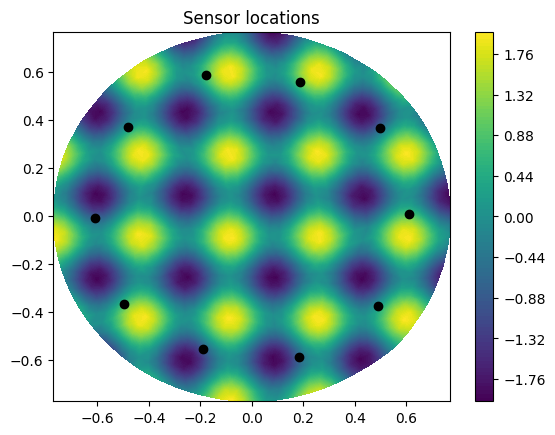

In [4]:
#Loading the desired dataset:

# path = "Data/pml_2d_circle_simple.csv"
# path = "Data/pml_2d_circle_plane_test.csv"
path = "Data/pml_2d_circle_plane_multi.csv"
# path = "Data/pml_2d_circle_gauss.csv"
# path = "Data/pml_2d_circle_alternating.csv"
# path = "Data/pml_2d_circle_mixed.csv"


data, tri = load_circle_comsol_data(path, verbose=True)

sensors = generate_circle_sensors_from_tri(10, tri)

#Visualization of the sensors
fig,ax = plt.subplots()
plt.title("Sensor locations")
cfg1 = ax.tricontourf(tri, data[-1,:], levels=100)
for i in sensors:
    ax.plot(tri.x[i],tri.y[i],color = "black", marker = "o")
fig.colorbar(cfg1, ax=ax)

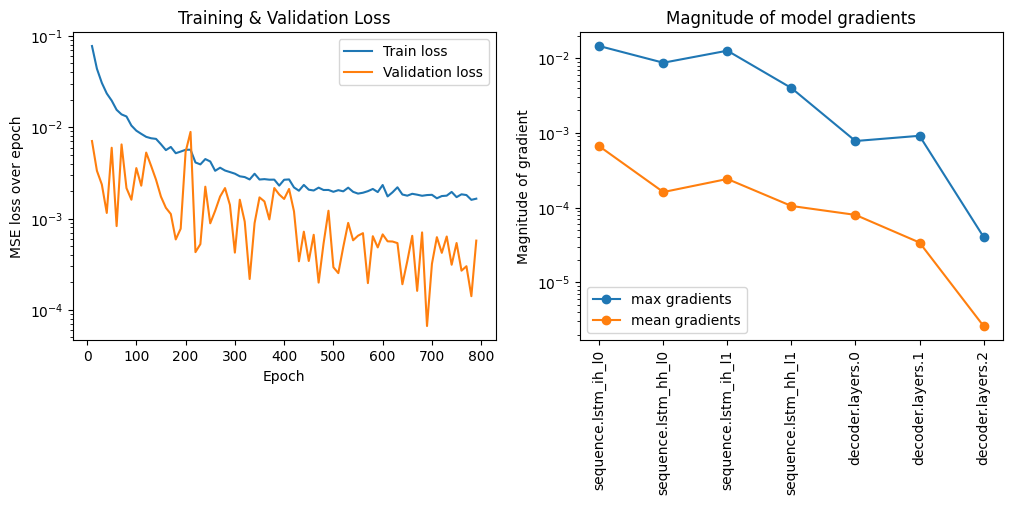

KeyboardInterrupt: 

In [22]:
data_test = []
data_test.append(data)
data_test.append(data)
data_test.append(data)
data_test.append(data)
data_test.append(data)
data_test.append(data)


lags = 40
X, y, scaler = data_prepare(data_test, lags, [s[0] for s in sensors])

data_save = {
    'X':X,
    'y':y,
    'scaler':scaler
}
data_all = SHREDdata(data_save)

train_dataset, val_dataset, test_dataset = data_all.split_data(train_ratio = 0.8, val_ratio=0.1, test_ratio=0.1, seed=42)

train_dataset.move_to_device(device)
val_dataset.move_to_device(device)
test_dataset.move_to_device(device)

pi_shred = PI_SHRED(sequence_model="LSTM",
    decoder_model="MLP")

val_errors = pi_shred.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=1000,
    batch_size= 128,
    verbose = False,
    plot = True,
    plot_modulo= 10,
    lr = 0.0003,
    patience = 1000
)

# Now we initialize the SHRED model

In [11]:
#Parameters that we need for the SHRED model:
lags = 40
model_dtype = torch.float32

manager = DataManager(
    lags = lags,
    train_size= 0.9,
    val_size = 0.1,
    test_size = 0.0, 
    model_dtype = model_dtype    
)

manager.add_data(
    data = data,
    id = "pml_2d_circle",
    # random = 3,
    stationary = sensors,
    compress = False
)

train_dataset, val_dataset, test_dataset= manager.prepare()

#Custom achitectures for the SHRED model
sequence_model = LSTM(
    hidden_size=64,
    num_layers=3
)
decoder_model = MLP(
    hidden_sizes=[64,64],
    dropout=0.1
)

shred = PI_SHRED(
    sequence_model="LSTM",
    decoder_model=decoder_model
)


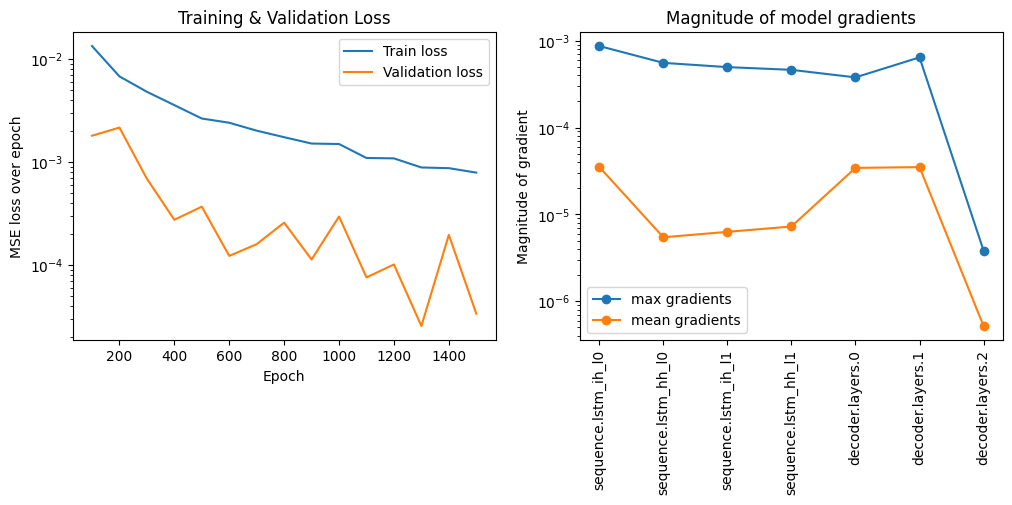

KeyboardInterrupt: 

In [12]:
# %matplotlib notebook
val_errors = shred.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=10000,
    batch_size= 128,
    verbose = False,
    plot= True,
    plot_modulo = 100,
    lr = 0.001,
    patience = 500000,
    model_dtype= model_dtype,
    optimizer="AdamW"
)


# Visualizing last layers

In [13]:
linear_layers = [m for m in shred.modules() if isinstance(m, torch.nn.Linear)]
# conv_layers = [m for m in shred.modules() if isinstance(m, torch.nn.Conv1d)]
last_layer = linear_layers[-1].weight.detach().cpu().numpy()
# print(test[:,0].shape)
last_layer_scaled = last_layer.copy()
for i in range(last_layer_scaled.shape[1]):
    last_layer_scaled[:,i] = manager.data_scaler.inverse_transform(last_layer[:,i].reshape(1,-1))

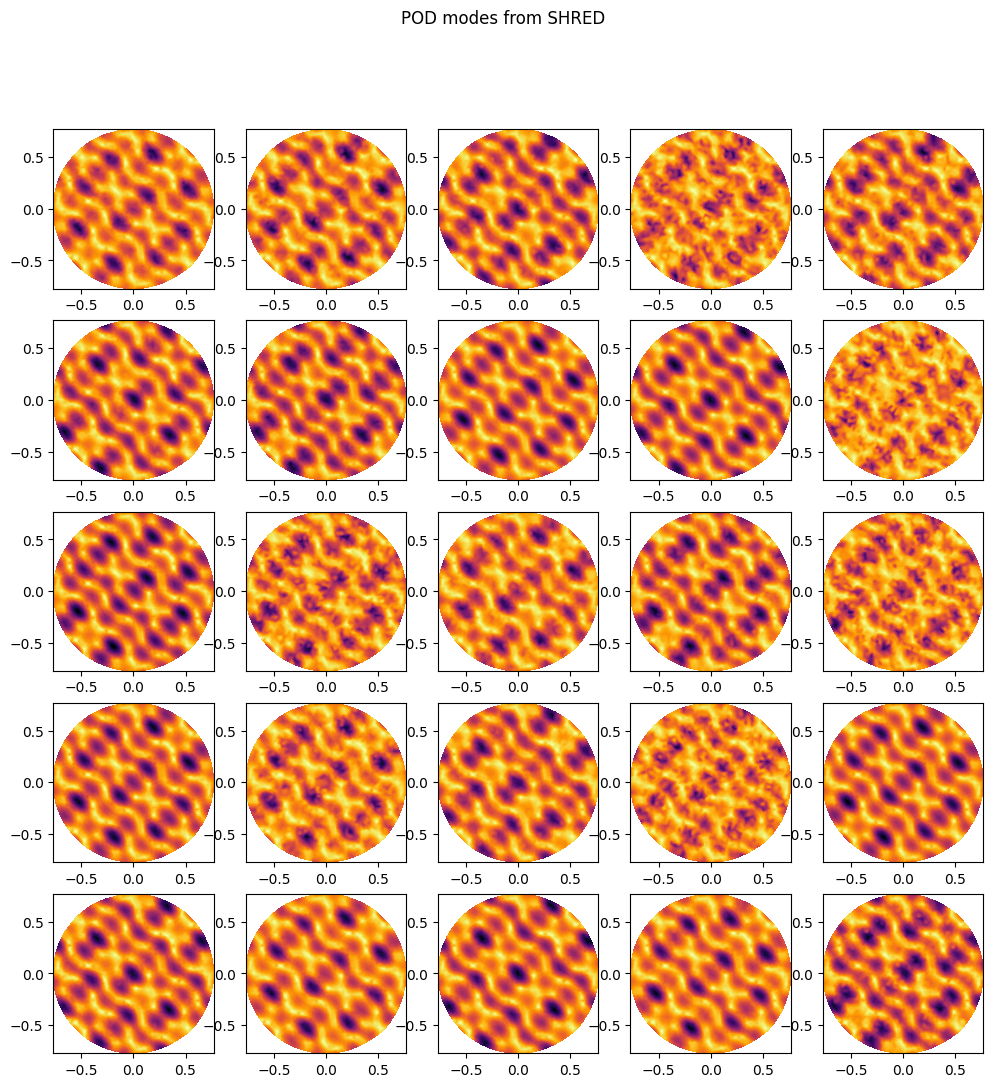

In [17]:
nr_frames = 5
counter = nr_frames**2*0
fig,ax = plt.subplots(nr_frames,nr_frames,figsize=(12,12))
for i in range(nr_frames):
    for j in range(nr_frames):
        ax[i,j].tricontourf(tri, last_layer_scaled[:,counter], levels=100,cmap = "inferno")
        # ax[i,j].tricontourf(tri, last_layer[:,counter], levels=100,cmap = "inferno")
        counter += 1
plt.suptitle("POD modes from SHRED")
plt.show()


# Doing the same but with SVD POD modes

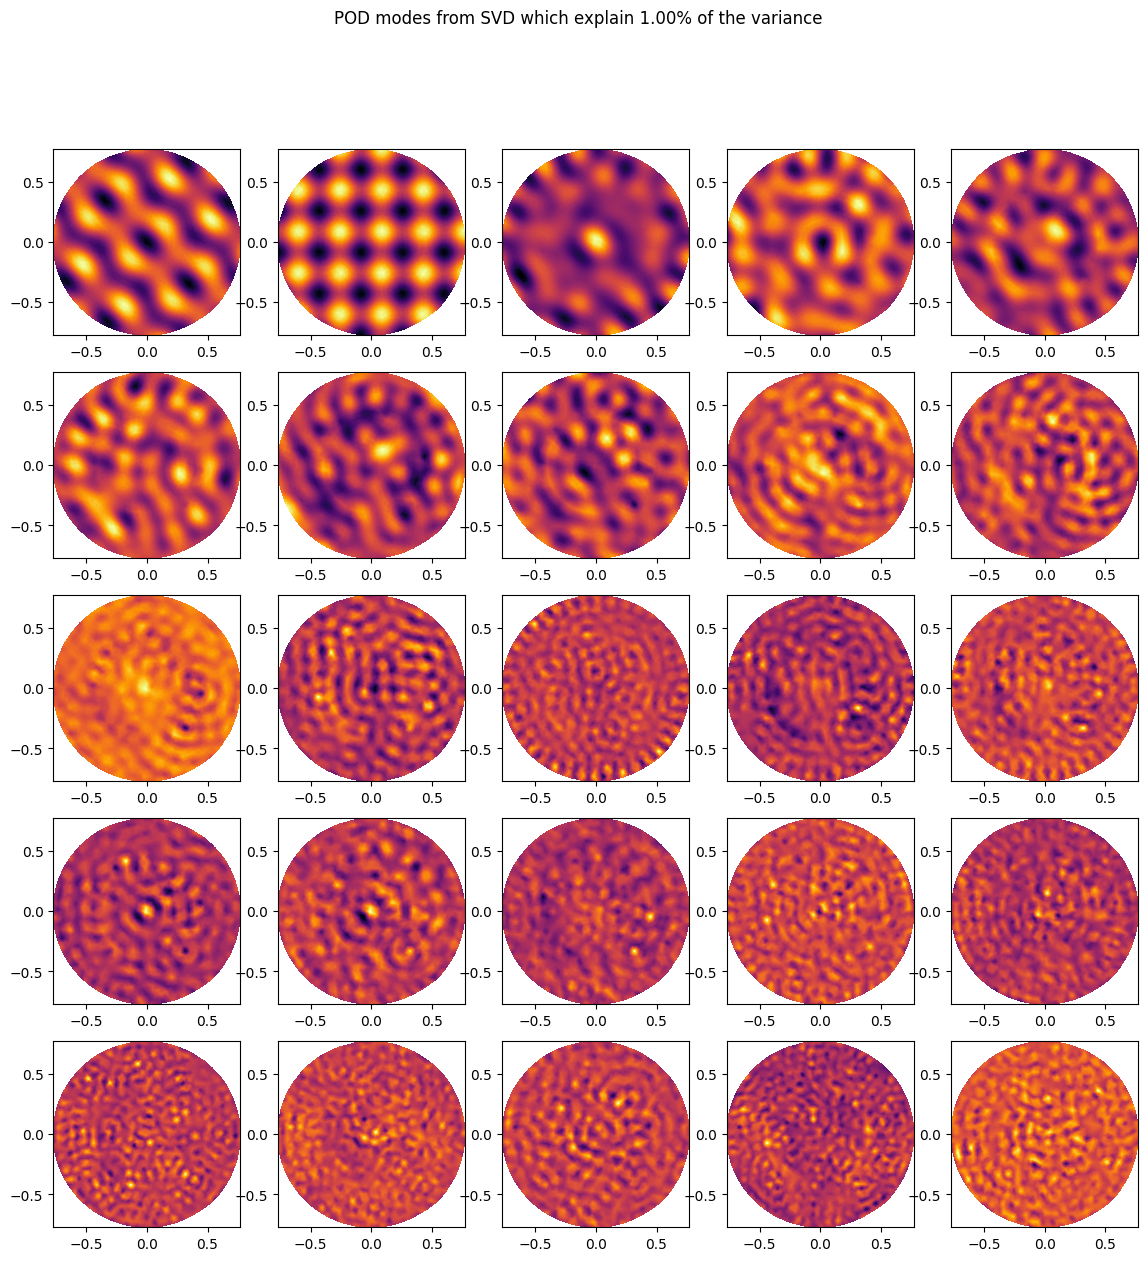

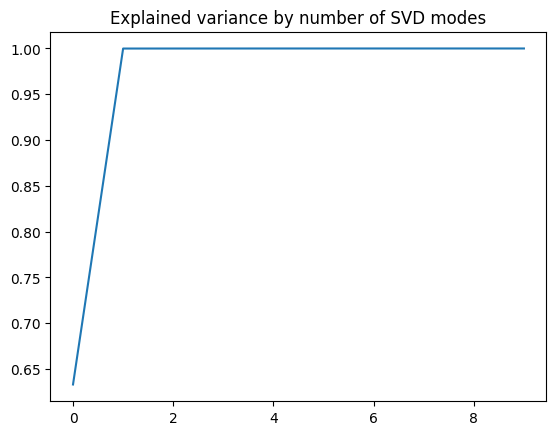

In [16]:
U,S,V = np.linalg.svd(data, full_matrices=False)
S_accum = np.cumsum(S)
S_accum = S_accum / S_accum[-1]

nr_frames = 5
counter = nr_frames**2*0

fig,ax = plt.subplots(nr_frames,nr_frames,figsize=(14,14))
plt.suptitle(f"POD modes from SVD which explain {S_accum[nr_frames**2]:.2f}% of the variance")
for i in range(nr_frames):
    for j in range(nr_frames):
        ax[i,j].tricontourf(tri, V[counter, :], levels=100,cmap = "inferno")
        counter += 1
plt.show()

fig,ax = plt.subplots()
ax.plot(S_accum[0:10])
plt.title("Explained variance by number of SVD modes")
plt.show()
# ax.set_yscale("log")

# Used for test predictions

0


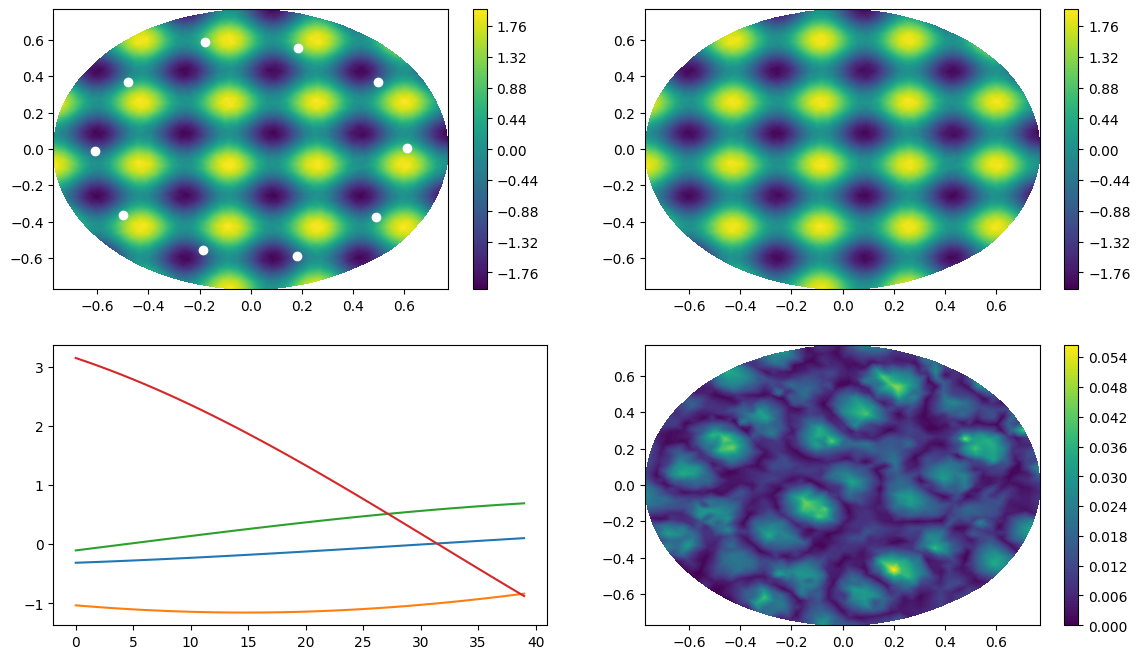

In [19]:
index = -1
print(len(test_dataset))
engine = SHREDEngine(manager, shred)
latens_from_sensor = engine.sensor_to_latent(manager.sensor_measurements)
model_reconstruction = engine.decode(latens_from_sensor)
model_inner = model_reconstruction["pml_2d_circle"][index,:]
# idx = manager.test_indices[index]

true_inner = data[index,:]

sensor_locs = manager.sensor_summary_df["loc/traj"]
test_sensor_trajs = manager.sensor_measurements[(index-lags):index]
fig,ax = plt.subplots(2,2,figsize = (14,8))
cfg1 = ax[0,0].tricontourf(tri, true_inner, levels=100)
for i in sensor_locs:
    ax[0,0].plot(tri.x[i],tri.y[i],color = "white",marker = "o")
cfg2 =ax[0,1].tricontourf(tri, model_inner, levels=100)
cfg3 = ax[1,1].tricontourf(tri, abs(model_inner-true_inner), levels=100)
for i in range(test_sensor_trajs.shape[1]):
    if i > 3:
        break
    ax[1,0].plot(test_sensor_trajs[:,i+4])
fig.colorbar(cfg1,ax=ax[0,0])
fig.colorbar(cfg2,ax=ax[0,1])
fig.colorbar(cfg3,ax= ax[1,1])


# Function which allows you to predict using sensor locations and data:

In [ ]:
path = "Data/pml_2d_circle_simple.csv"
# path = "Data/pml_2d_circle_plane_test.csv"
# path = "Data/pml_2d_circle_gauss.csv"
# path = "Data/pml_2d_circle_alternating.csv"
# path = "Data/pml_2d_circle_mixed.csv"

file_path = "Data/"
data_tes, tri_test = load_circle_comsol_data(path, verbose=True)



# Generating all the frames used to make GIF and movie

starting loop 151
starting loop 152
starting loop 153


KeyboardInterrupt: 

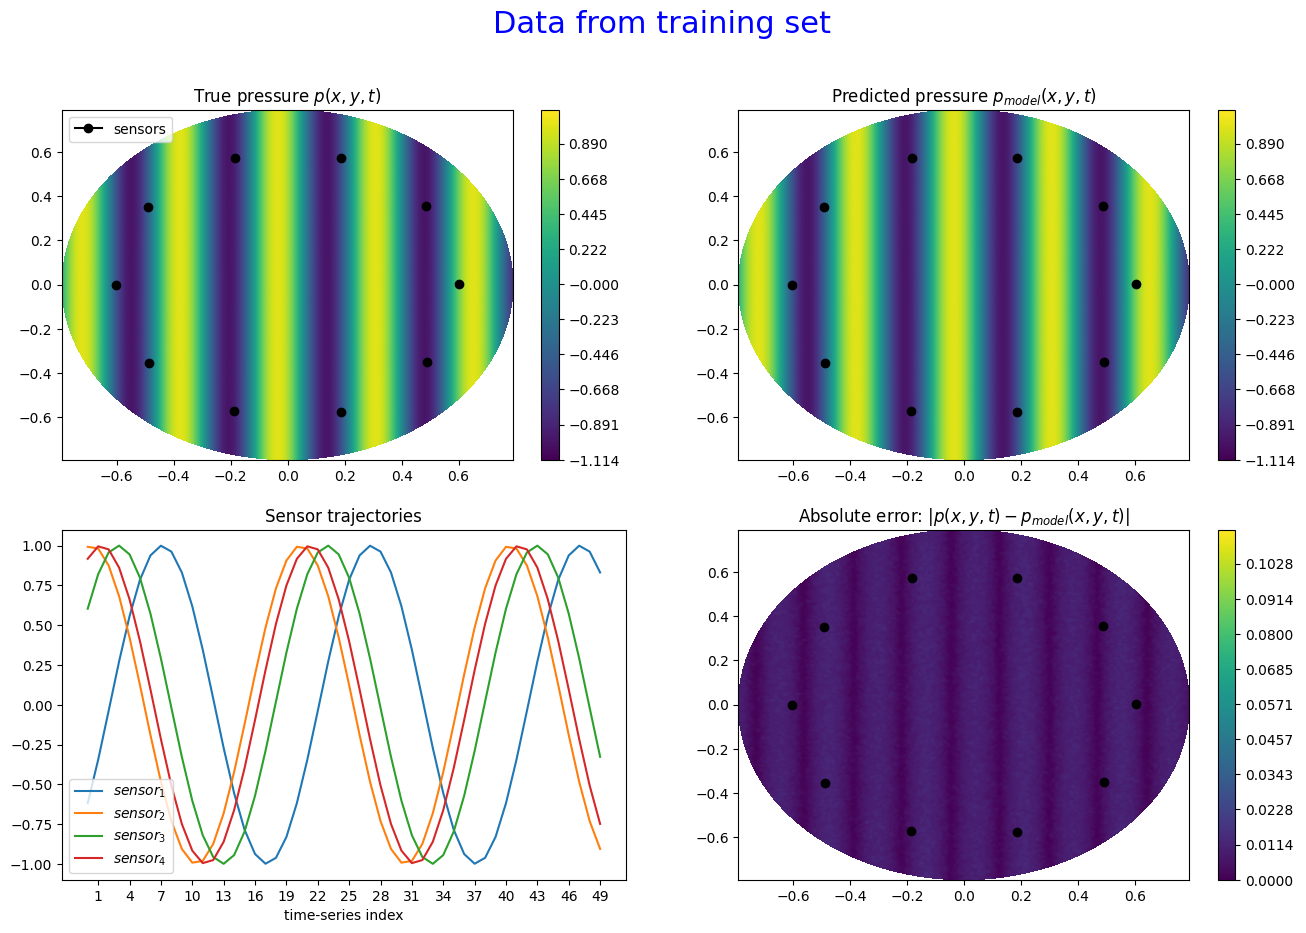

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from matplotlib.colors import TwoSlopeNorm


engine = SHREDEngine(manager, shred)
latens_from_sensor = engine.sensor_to_latent(manager.sensor_measurements)
reconstruction_all = engine.decode(latens_from_sensor)

errors = abs(data - reconstruction_all["pml_2d_circle"])


max_val = np.max(reconstruction_all["pml_2d_circle"])
min_val = np.min(reconstruction_all["pml_2d_circle"])

max_error = np.max(errors)
min_error = np.min(errors)

train_max_idx = max(manager.train_indices)
val_max_idx = max(manager.val_indices)

pred_levels = np.linspace(min_val*1.1,max_val*1.1, 300)
error_levels = np.linspace(0,max_error*1.1, 300)

# index = lags+500
index = len(reconstruction_all["pml_2d_circle"])-(100)
images = []
x_ticks = np.arange(1,lags,3)

while index < latens_from_sensor.shape[0]:
    print(f"starting loop {index-lags}")
    test_inner = reconstruction_all["pml_2d_circle"][index,:]
    
    true_inner = data[index,:]

    sensor_locs = manager.sensor_summary_df["loc/traj"]
    sensor_trajs = manager.sensor_measurements[(index-lags):index]

    fig,ax = plt.subplots(2,2,figsize = (16,10))
    if index <= train_max_idx:
        plt.suptitle("Data from training set",fontsize = 22, color = "blue")
    elif index <= val_max_idx:
        plt.suptitle("Data from validation set",fontsize = 22, color = "green")
    else:
        plt.suptitle("Data from test set",fontsize = 22, color = "red")
    cfg1 = ax[0,0].tricontourf(tri, true_inner, levels=pred_levels)

    for i in sensor_locs:
        if i == sensor_locs[0]:
            ax[0,0].plot(tri.x[i],tri.y[i],color = "black",marker = "o",label = 'sensors')
            ax[0,1].plot(tri.x[i],tri.y[i],color = "black",marker = "o",label = 'sensors')
            ax[1,1].plot(tri.x[i],tri.y[i],color = "black",marker = "o",label = 'sensors')
        else:
            ax[0,0].plot(tri.x[i],tri.y[i],color = "black",marker = "o")
            ax[0,1].plot(tri.x[i],tri.y[i],color = "black",marker = "o")
            ax[1,1].plot(tri.x[i],tri.y[i],color = "black",marker = "o")
    cfg2 =ax[0,1].tricontourf(tri, test_inner, levels=pred_levels,label = "Model prediction")
    cfg3 = ax[1,1].tricontourf(tri, abs(test_inner-true_inner), levels=error_levels,label = "absolute difference")
    for i in range(sensor_trajs.shape[1]):
        if i > 3:
            break
        ax[1,0].plot(sensor_trajs[:,i], label =f"$sensor_{i+1}$")
        
    ax[0,0].set_title(r"True pressure $p(x,y,t)$")
    ax[0,1].set_title(r"Predicted pressure $p_{model}(x,y,t)$")
    ax[1,0].set_title(r"Sensor trajectories")
    ax[1,1].set_title(r"Absolute error: $|p(x,y,t)-p_{model}(x,y,t)|$")
    ax[1,0].legend(loc = "lower left")
    ax[0,0].legend(loc = "upper left")
    ax[1,0].set_xticks(x_ticks)
    ax[1,0].set_xlabel("time-series index")


    fig.colorbar(cfg1,ax=ax[0,0])
    fig.colorbar(cfg2,ax=ax[0,1])
    fig.colorbar(cfg3,ax= ax[1,1])
    
    buf = BytesIO()
    plt.savefig(buf, format = 'png')
    buf.seek(0)
    images.append(Image.open(buf))
    plt.close(fig)
    index +=1

# images[0].save("plane.gif", save_all = True, append_images = images[1:],duration = 250, loop= 0)
# images[0].save("gauss.gif", save_all = True, append_images = images[1:],duration = 400, loop= 0)
# images[0].save("gauss.gif", save_all = True, append_images = images[1:],duration = 400, loop= 0)


In [51]:
images[0].save("Visualizations/gauss_alternate.gif", save_all = True, append_images = images[1:],duration = 300, loop= 0,dpi = 200)

# Creating the movie

In [52]:
import numpy as np
import imageio.v2 as imageio

fps = 4  # try 5–10
crf = "22"  # lower = better quality, bigger file. Typical: 18–28

with imageio.get_writer(
    "gauss_alternate.mp4",
    fps=fps,
    codec="libx264",
    format="FFMPEG",
    output_params=[
        "-pix_fmt", "yuv420p",   # widest compatibility
        "-crf", crf,             # quality target
        "-preset", "slow",       # slower = smaller file (try 'medium'/'slow')
        "-movflags", "+faststart"
    ]
) as w:
    for im in images:
        # (Optional) downscale frames before writing, e.g. to 1280px width
        # im = im.resize((1280, int(1280*im.height/im.width)), Image.LANCZOS)
        w.append_data(np.array(im.convert("RGB")))

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1600, 1000) to (1600, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x3d078340] Stream #0: not enough frames to estimate rate; consider increasing probesize
Multiple -pix_fmt options specified for stream 0, only the last option '-pix_fmt yuv420p' will be used.


# Used for debugging plot setup for movies

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

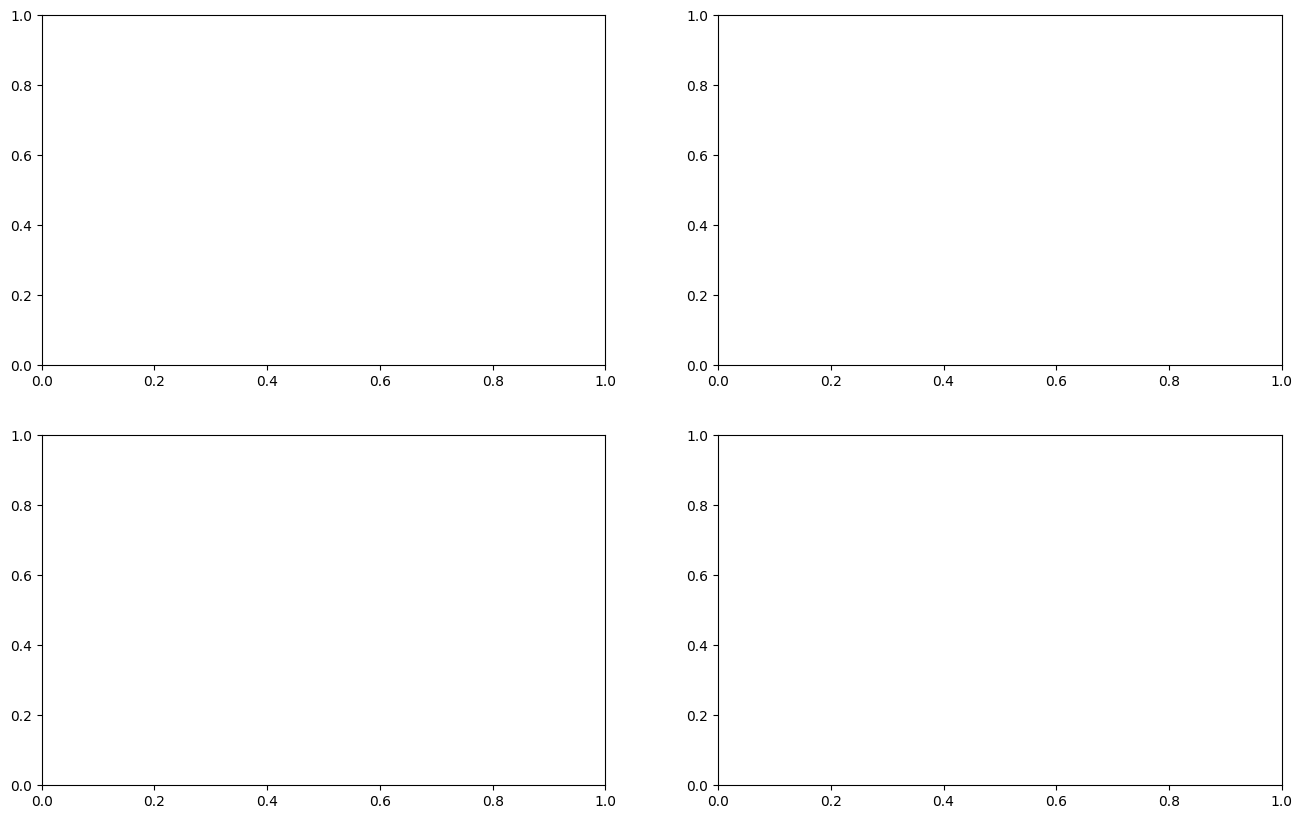

In [ ]:
norm_u = TwoSlopeNorm(vmin=min_val, vcenter=0.0, vmax=max_val)
x_ticks = np.arange(1,lags,3)
cbar_ticks = np.linspace(min_val,max_val, 10)
levels_u  = np.linspace(min_val*1.1,  max_val*1.1, 201)   # true/prediction

train_max_idx = max(manager.train_indices)
val_max_idx = max(manager.val_indices)
fig,ax = plt.subplots(2,2,figsize = (16,10))
if index <= train_max_idx:
    plt.suptitle("Data from training set",fontsize = 18,color = "green")
elif index <= val_max_idx:
    plt.suptitle("Data from validation set",fontsize = 18,color = "blue")
else:
    plt.suptitle("Data from test set",fontsize = 18,color = "red")
cfg1 = ax[0,0].tricontourf(tri, true_inner, levels=levels_u)

for i in sensor_locs:
    print(i)
    if i == sensor_locs[0]:
        ax[0,0].plot(tri.x[i],tri.y[i],color = "black",marker = "o",label = 'sensors')
        print("hej")
    else:
        ax[0,0].plot(tri.x[i],tri.y[i],color = "black",marker = "o")

cfg2 =ax[0,1].tricontourf(tri, test_inner, levels=levels_u,label = "Model prediction")
cfg3 = ax[1,1].tricontourf(tri, abs(test_inner-true_inner), levels=error_levels,label = "absolute difference")
for i in range(test_sensor_trajs.shape[1]):
    if i > 3:
        break
    ax[1,0].plot(sensor_trajs[:,i], label =f"$sensor_{i+1}$")

ax[0,0].set_title(r"True solution $u(x,y,t)$")
ax[0,1].set_title(r"Model prediction $u_{model}(x,y,t)$")
ax[1,0].set_title(r"Sensor trajectories")
ax[1,1].set_title(r"Absolute error: $|u(x,y,t)-u_{model}(x,y,t)|$")
ax[1,0].legend(loc = "lower left")
ax[0,0].legend(loc = "upper left")
ax[1,0].set_xticks(x_ticks)
ax[1,0].set_xlabel("time-series index")

fig.colorbar(cfg1,ax=ax[0,0])
fig.colorbar(cfg2,ax=ax[0,1])
fig.colorbar(cfg3,ax= ax[1,1])
    
